# Тюнинг линейной регрессии и ошибки

### О задании

В этом задании вы:
- обучите линейную регрессию, познакомитесь с метриками качества в задачах регресии

In [1]:
%pylab inline
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Часть 1. Линейная регрессия

Для начала загрузим данные и разделим их на обучающую и тестовую выборки в соотношении 7 к 3. Зачем так делать? Когда вы проверяете себя на данных на которых не обучались, вы можете быть уверены что не переобучились. Таким образом если качество на 70% датасета (оубчающей выборке) растёт, а на тестовой выборке падает, то модель начала запоминать датасет (переобучилась), вы что-то делаете не так.


In [2]:
data = load_diabetes()
x_train, x_test, y_train, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)

__Задание 1.__ Обучение линейной регрессии.

**(4 балла)**

Обучите линейную регрессию с $L_1$ (Lasso) и $L_2$ (Ridge) регуляризаторами (используйте параметры по умолчанию). Посмотрите, какое количество коэффициентов близко к 0 (степень близости к 0 определите сами из разумных пределов). Постройте график зависимости числа ненулевых коэффициентов от коэффицента регуляризации (перебирайте значения по логарифмической сетке от $10^{-3}$ до $10^3$).

In [3]:
from sklearn import datasets, linear_model
from sklearn.linear_model import Ridge, Lasso
import numpy as np

In [4]:
EPS = 2
alphas = []
for p in range(-3, 3):
     for i in range(1, 10):
         alpha = i * (10 ** p)
         alphas.append(alpha)

In [5]:
import math
from joblib import Parallel, delayed

def f(alpha):
    regression = linear_model.Lasso(alpha=alpha)
    regression.fit(x_train, y_train)
    prediction = regression.predict(x_test)
    ret = 0
    for i in regression.coef_:
        ret += i < 0.1
    return ret

Lasso_cnts = Parallel(n_jobs=-1)(delayed(f)(alpha) for alpha in alphas)

In [14]:
import math
from joblib import Parallel, delayed

def f(alpha):
    regression = linear_model.Ridge(alpha=alpha)
    regression.fit(x_train, y_train)
    prediction = regression.predict(x_test)
    ret = 0
    for i in regression.coef_:
        ret += i < 2
    return ret

Ridge_cnts = Parallel(n_jobs=-1)(delayed(f)(alpha) for alpha in alphas)

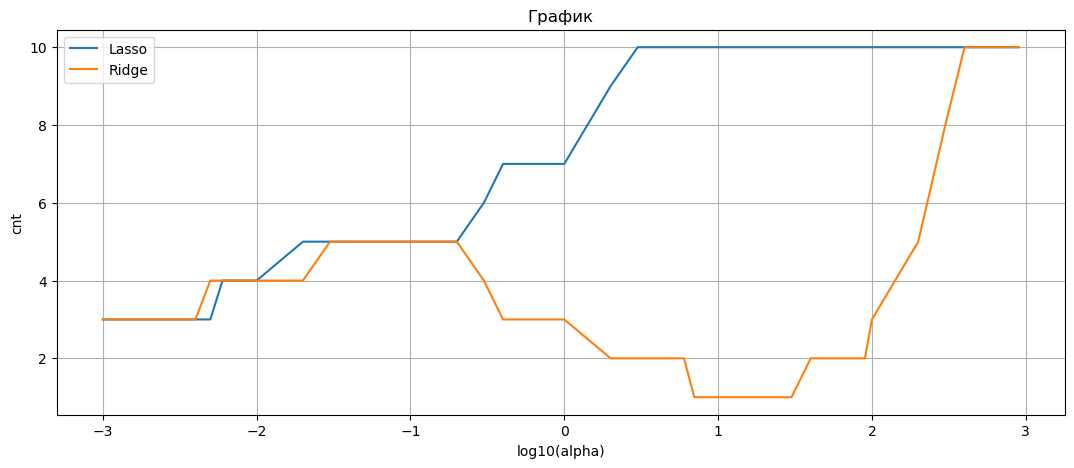

In [15]:
f, (ax) = plt.subplots(1, 1, figsize=(13, 5))
ax.plot([math.log(i, 10) for i in alphas], Lasso_cnts, label='Lasso')
ax.plot([math.log(i, 10) for i in alphas], Ridge_cnts, label='Ridge')
ax.set_title(u"График")
ax.set_xlabel(u"log10(alpha)")
ax.set_ylabel(u"cnt")
ax.grid()
ax.legend()

Посчитайте для Ridge-регрессии следующие метрики: $RMSE$, $MAE$, $R^2$.

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
regression = linear_model.Ridge()
regression.fit(x_train, y_train)
prediction = regression.predict(x_test)

MSE = mean_squared_error(y_test, prediction)
RMSE = MSE ** 0.5
print("RMSE:", RMSE)

MAE = mean_absolute_error(y_test, prediction)
print("MAE:", MAE)

R2 = r2_score(y_test, prediction)
print("R2:", R2)

RMSE: 58.304295113912275
MAE: 49.602750809651916
R2: 0.359902022000946


Подберите на обучающей выборке для Ridge-регрессии коэффициент регуляризации (перебирайте значения по логарифмической сетке от $10^{-3}$ до $10^3$) для каждой из метрик. Постройте графики зависимости фукнции потерь от коэффициента регуляризации. Посчитайте те же метрики снова. Заметно ли изменилось качество?

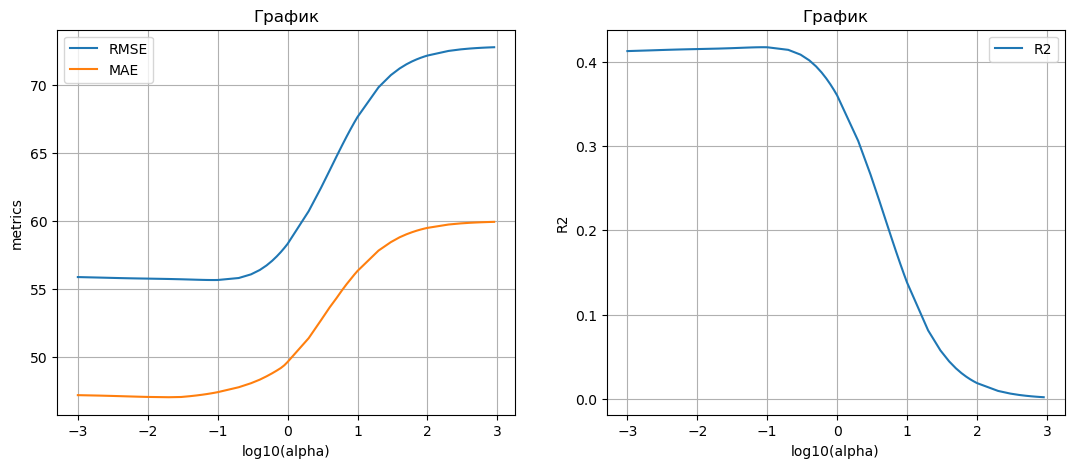

In [10]:
RMSEs, MAEs, R2s = [], [], []
for alpha in alphas:
    regression = linear_model.Ridge(alpha=alpha)
    regression.fit(x_train, y_train)
    prediction = regression.predict(x_test)

    MSE = mean_squared_error(y_test, prediction)
    RMSE = MSE ** 0.5
    RMSEs.append(RMSE)

    MAE = mean_absolute_error(y_test, prediction)
    MAEs.append(MAE)

    R2 = r2_score(y_test, prediction)
    R2s.append(R2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

ax1.plot([math.log(i, 10) for i in alphas], RMSEs, label='RMSE')
ax1.plot([math.log(i, 10) for i in alphas], MAEs, label='MAE')
ax1.set_title(u"График")
ax1.set_xlabel(u"log10(alpha)")
ax1.set_ylabel(u"metrics")
ax1.grid()
ax1.legend()

ax2.plot([math.log(i, 10) for i in alphas], R2s, label='R2')
ax2.set_title(u"График")
ax2.set_xlabel(u"log10(alpha)")
ax2.set_ylabel(u"R2")
ax2.grid()
ax2.legend()

In [12]:
regression = linear_model.Ridge(alpha=0.1)
regression.fit(x_train, y_train)
prediction = regression.predict(x_test)

MSE = mean_squared_error(y_test, prediction)
RMSE = MSE ** 0.5
print("RMSE:", RMSE)

MAE = mean_absolute_error(y_test, prediction)
print("MAE:", MAE)

R2 = r2_score(y_test, prediction)
print("R2:", R2)

RMSE: 55.64176122404913
MAE: 47.3754637570613
R2: 0.41702880920983465


**Качество заметно улучшилось.**

__Задание 2.__ Поиск объектов-выбросов

**(4 балла)**

Как известно, MSE сильно штрафует за большие ошибки на объектах-выбросах. Посчитайте ошибки и посмотрите на их распределение (plt.hist). Что вы видите?

(array([65., 30., 14.,  6.,  6.,  6.,  2.,  2.,  1.,  1.]),
 array([3.34838909e+00, 1.79629293e+03, 3.58923747e+03, 5.38218201e+03,
        7.17512655e+03, 8.96807109e+03, 1.07610156e+04, 1.25539602e+04,
        1.43469047e+04, 1.61398492e+04, 1.79327938e+04]),
 <BarContainer object of 10 artists>)

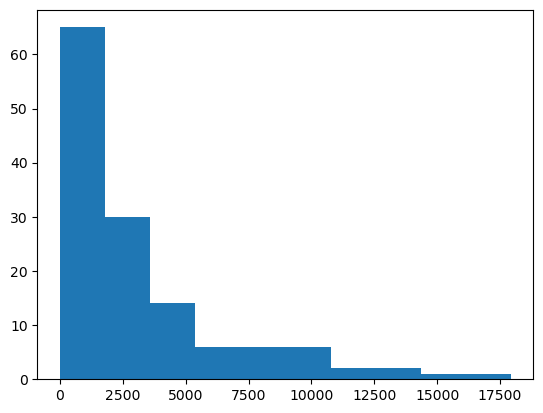

In [17]:
errors = []
for i in range(len(x_test)):
    errors.append(mean_squared_error([y_test[i]], [prediction[i]]))
errors = np.array(errors)
plt.hist(errors)

**Чем больше значение ошибки, тем меньше таких ошибок. (Форма распределения напоминает левую ветвь параболы $y=x^2$.) Видно, что есть очень большие ошибки, но их мало. Очевидно, что выбросов не так много.**

Попробуйте удалить объекты-выбросы из обучающей выборки (что считать или не считать выбросами на ваше усмотрение). Обучите модель заново и посмотрите на качество на отложенной выборке (учитывайте, что там тоже могут быть выбросы, с которыми вы ничего не можете сделать). Стало ли лучше? Чем вы можете объяснить это?

In [27]:
regression = linear_model.Ridge(alpha=0.1)
regression.fit(x_train, y_train)
prediction_train = regression.predict(x_train)

error_threshold = 6000
indexes = ((y_train - prediction_train) ** 2) <= error_threshold
new_x_train, new_y_train = x_train[indexes], y_train[indexes]

regression = linear_model.Ridge(alpha=0.1)
regression.fit(new_x_train, new_y_train)
prediction = regression.predict(x_test)

MSE = mean_squared_error(y_test, prediction)
RMSE = MSE ** 0.5
print("RMSE:", RMSE)

MAE = mean_absolute_error(y_test, prediction)
print("MAE:", MAE)

R2 = r2_score(y_test, prediction)
print("R2:", R2)

RMSE: 54.92861954401778
MAE: 46.33819639653927
R2: 0.4318765364891768


Стало лучше, потому что раньше выбросы слишком сильно влияли на модель, так как ошибка была очень большой. ![](image.png)

__Задание 3.__ Отчёт

**(2 балла)**

*Удаление выбросов может быть эффективно, если эти выбросы являются некорректными данными или аномалиями. Но с этим надо быть осторожнее, потому что могут быть выбросы, с которыми тоже надо уметь правильно работать.
Также я рассмотрел разные способы подсчёта ошибок и сравнил их.*